<a href="https://colab.research.google.com/github/luquelab/bioinformatics-teamwinners/blob/colab_dev/notebooks/sequence_analysis_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install BioPython

In [ ]:
# Install BioPython
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.7 MB/s eta 0:00:00


## Load in fna files (sequences)


In [ ]:
from Bio import SeqIO
import matplotlib.pyplot as plt
from Bio.SeqRecord import SeqRecord
import subprocess
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio import AlignIO
import os
import numpy as np
import pandas as pd

!apt-get update -q
!apt-get install -y -q mafft

/usr/local/lib/python3.11/dist-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,383 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,824 kB]
Get:13 https://r2u.stat.illinois.edu/ubu

In [ ]:
nucleotide_sequence_path =  "/content/sequences.fna"
amino_acid_sequence_path = "/content/results/sequences_translated.faa"
nucleotide_alignment_path = "/content/results/alignments/nucleotide_alignments.aln"
protein_alignment_path = "/content/results/alignments/protein_alignments.aln"
similarities_protein_csv = "/content/results/alignments/protein_similarity.csv"
similarities_nucleotide_csv = "/content/results/alignments/nucleotide_similarity.csv"
nucleotide_tree_path = "/content/results/phylogenetic_tree/tree_nucleotides.nwk"
nucleotide_tree_image = "/content/results/phylogenetic_tree/tree_nucleotides.png"
protein_tree_path = "/content/results/phylogenetic_tree/tree_proteins.nwk"
protein_tree_image = "/content/results/phylogenetic_tree/tree_proteins.png"
functional_prediction_path = "/content/results/functional_prediction"


In [ ]:
import os

# File paths
nucleotide_sequence_path =  "/content/sequences.fna"
amino_acid_sequence_path = "/content/results/sequences_translated.faa"
nucleotide_alignment_path = "/content/results/alignments/nucleotide_alignments.aln"
protein_alignment_path = "/content/results/alignments/protein_alignments.aln"
similarities_protein_csv = "/content/results/alignments/protein_similarity.csv"
similarities_nucleotide_csv = "/content/results/alignments/nucleotide_similarity.csv"
nucleotide_tree_path = "/content/results/phylogenetic_tree/tree_nucleotides.nwk"
nucleotide_tree_image = "/content/results/phylogenetic_tree/tree_nucleotides.png"
protein_tree_path = "/content/results/phylogenetic_tree/tree_proteins.nwk"
protein_tree_image = "/content/results/phylogenetic_tree/tree_proteins.png"
functional_prediction_path = "/content/results/functional_prediction"

# List of output paths
output_paths = [
    amino_acid_sequence_path,
    nucleotide_alignment_path,
    protein_alignment_path,
    similarities_protein_csv,
    similarities_nucleotide_csv,
    nucleotide_tree_path,
    nucleotide_tree_image,
    protein_tree_path,
    protein_tree_image,
    functional_prediction_path
]

# Create directories
print("Setting up directories...")
for path in output_paths:
    directory = os.path.dirname(path)
    if directory and not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
        print(f"Created: {directory}")

# Check input file
if not os.path.exists(nucleotide_sequence_path):
    print(f"\nWarning: Input file missing at {nucleotide_sequence_path}. Please upload it.")
else:
    print(f"\nInput file ready: {nucleotide_sequence_path}")

Setting up directories...
Created: /content/results
Created: /content/results/alignments
Created: /content/results/phylogenetic_tree

Input file ready: /content/sequences.fna


## Analyze sequence properties

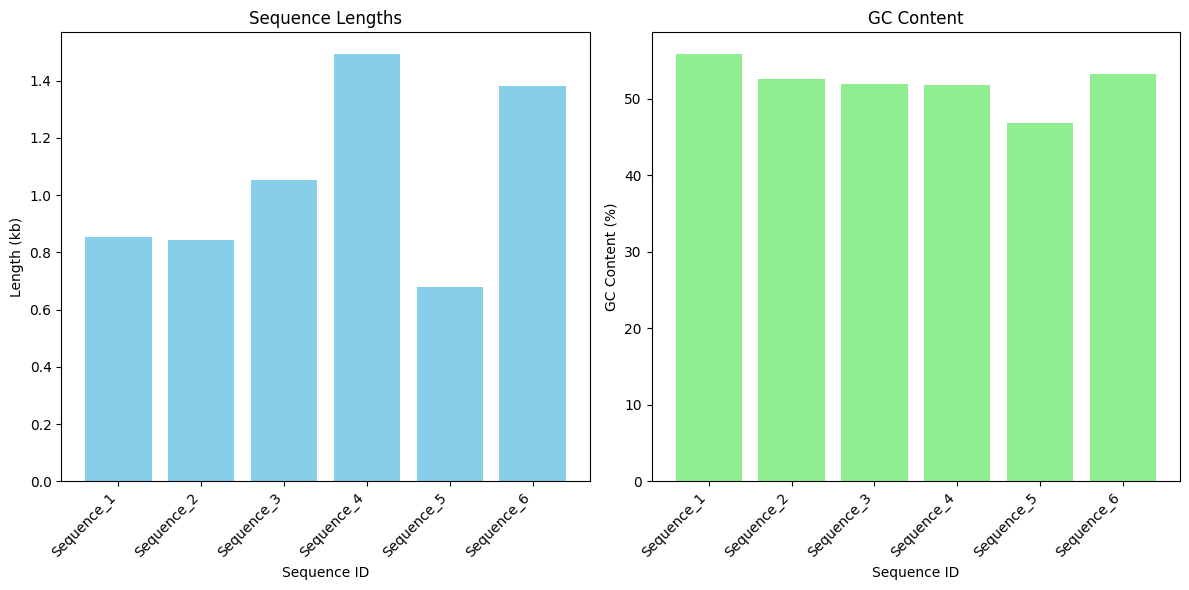

In [ ]:
def gc_content(seq):
    gc_count = seq.count('g') + seq.count('c')
    return (gc_count / len(seq)) * 100 if len(seq) > 0 else 0

def analyze_sequences(fasta_file):
    sequence_lengths = []
    gc_contents = []
    sequence_ids = []

    for record in SeqIO.parse(fasta_file, "fasta"):
        sequence_lengths.append(len(record.seq) / 1000)
        gc_contents.append(gc_content(str(record.seq)))
        sequence_ids.append(record.id)


    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(sequence_ids, sequence_lengths, color='skyblue')
    plt.xlabel("Sequence ID")
    plt.ylabel("Length (kb)")
    plt.title("Sequence Lengths")
    plt.xticks(rotation=45, ha="right")

    plt.subplot(1, 2, 2)
    plt.bar(sequence_ids, gc_contents, color='lightgreen')
    plt.xlabel("Sequence ID")
    plt.ylabel("GC Content (%)")
    plt.title("GC Content")
    plt.xticks(rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

analyze_sequences(nucleotide_sequence_path)


## Translate the sequences

In [ ]:
def translate_sequences(input_fasta, output_faa):
    translated_records = []

    for record in SeqIO.parse(input_fasta, "fasta"):
        # Translate only in frame 1 (starting at position 0)
        dna = record.seq[0:]  # or just record.seq
        protein = dna.translate()

        trans_record = SeqRecord(
            protein,
            id=f"{record.id}_frame1",
            description=f"Translation of {record.id} in reading frame 1"
        )
        translated_records.append(trans_record)

    SeqIO.write(translated_records, output_faa, "fasta")
    print(f"Translated sequences saved to {output_faa}")

translate_sequences(nucleotide_sequence_path, amino_acid_sequence_path)

Translated sequences saved to /content/results/sequences_translated.faa


## Alignment of nucleotide sequences and protein sequences.

In [ ]:
from Bio.Align.Applications import MafftCommandline


# Define input and output files
nucleotide_input = nucleotide_sequence_path
protein_input = amino_acid_sequence_path
nucleotide_output_aln = nucleotide_alignment_path
protein_output_aln = protein_alignment_path

# Check if input files exist
for infile in (nucleotide_input, protein_input):
    if not os.path.exists(infile):
        raise FileNotFoundError(f"Input file '{infile}' not found. Please upload it.")

# Nucleotide alignment with MAFFT
mafft_nucleotide = MafftCommandline(cmd="mafft", input=nucleotide_input)

print("Running MAFFT for nucleotide alignment...")
try:
    stdout, stderr = mafft_nucleotide()
    with open(nucleotide_output_aln, "w") as f:
        f.write(stdout)
except Exception as e:
    raise RuntimeError(f"MAFFT nucleotide alignment failed: {str(e)}")

if not os.path.exists(nucleotide_output_aln):
    raise FileNotFoundError(f"Failed to generate '{nucleotide_output_aln}'.")

# Protein alignment with MAFFT
mafft_protein = MafftCommandline(cmd="mafft", input=protein_input)

print("Running MAFFT for protein alignment...")
try:
    stdout, stderr = mafft_protein()
    with open(protein_output_aln, "w") as f:
        f.write(stdout)
except Exception as e:
    raise RuntimeError(f"MAFFT protein alignment failed: {str(e)}")

if not os.path.exists(protein_output_aln):
    raise FileNotFoundError(f"Failed to generate '{protein_output_aln}'.")

# Convert FASTA to Clustal format
for aln_file in (nucleotide_output_aln, protein_output_aln):
    alignment = AlignIO.read(aln_file, "fasta")
    with open(aln_file, "w") as f:
        AlignIO.write(alignment, f, "clustal")

# Read and display alignments
print("\nNucleotide Alignment:")
nucleotide_alignment = AlignIO.read(nucleotide_output_aln, "clustal")
print(nucleotide_alignment)

print("\nProtein Alignment:")
protein_alignment = AlignIO.read(protein_output_aln, "clustal")
print(protein_alignment)

# Distance matrix calculation
def calculate_distance_matrix(alignment):
    num_seqs = len(alignment)
    dist_matrix = np.zeros((num_seqs, num_seqs))
    for i in range(num_seqs):
        for j in range(i + 1, num_seqs):
            mismatches = sum(1 for a, b in zip(alignment[i], alignment[j]) if a != b)
            dist_matrix[i, j] = mismatches / len(alignment[i])
            dist_matrix[j, i] = dist_matrix[i, j]
    return dist_matrix

# Calculate distance matrices
nucleotide_distances = calculate_distance_matrix(nucleotide_alignment)
protein_distances = calculate_distance_matrix(protein_alignment)

print("\nNucleotide Distance Matrix:")
print(nucleotide_distances)

print("\nProtein Distance Matrix:")
print(protein_distances)

# Similarity calculation with CSV export
def calculate_similarity(dist_matrix, alignment, output_csv):
    similarity_matrix = 1 - dist_matrix
    np.fill_diagonal(similarity_matrix, np.nan)

    # Create DataFrame with sequence IDs as index and columns
    seq_ids = [seq.id for seq in alignment]
    sim_df = pd.DataFrame(similarity_matrix, index=seq_ids, columns=seq_ids)

    # Save to CSV
    sim_df.to_csv(output_csv)
    print(f"Similarity matrix saved to {output_csv}")

    return np.nanmean(similarity_matrix)

# Calculate similarities and save to CSV
nucleotide_similarity = calculate_similarity(nucleotide_distances, nucleotide_alignment, similarities_nucleotide_csv)
protein_similarity = calculate_similarity(protein_distances, protein_alignment, similarities_protein_csv)

print(f"\nAverage Nucleotide Similarity: {nucleotide_similarity:.2%}")
print(f"Average Protein Similarity: {protein_similarity:.2%}")

Running MAFFT for nucleotide alignment...
Running MAFFT for protein alignment...

Nucleotide Alignment:
Alignment with 6 rows and 1825 columns
----------------atggcgaac-------------------...--- Sequence_1
----------------atggcg----------------------...--- Sequence_2
atgaccgtgaaag-cgatggcgctg---------------aaca...--- Sequence_3
atgagcaaaa----ttgcggtgatttatgcgcgctatagcagcg...ttt Sequence_4
atgtgcgtg------tatggctatt-------gccgcattagca...--- Sequence_5
atgagccgcaccctgagcggcgatc------------atcagta...--- Sequence_6

Protein Alignment:
Alignment with 6 rows and 627 columns
-----MANTINLVTKFAPYVDEQFTS------------ESKLS-...--- Sequence_1_frame1
-----MA--IDLVAKFLPYVDEMFTT------------ESKKS-...--- Sequence_2_frame1
MTVKAMALNTNQLFAYLN-----------RGDIA----EFKFS-...--- Sequence_3_frame1
-----MS---KIAVIYARYSSDKQTEDSIEAQVRACR-EYAAAH...ATF Sequence_4_frame1
----------MCVYGYCRISTKQQSI---ERQIRNIKAEYDKA-...--- Sequence_5_frame1
-----MS---RTLSGDHQYYLDKYAK---MAKAAALE-EQRAA-...--- Sequence_6_frame1

Nucleotide D

In [ ]:
# Create a matrix containing the paired distances between the nucleotide sequences

import numpy as np

# Assuming 'prot_alignment' is your protein alignment object from Biopython
# and you want to compute the distance matrix

num_sequences = len(prot_alignment)
distance_matrix = np.zeros((num_sequences, num_sequences))

for i in range(num_sequences):
    for j in range(i + 1, num_sequences):
        seq1 = prot_alignment[i]
        seq2 = prot_alignment[j]

        distance = 0  # Initialize the distance
        for k in range(len(seq1)):
            if seq1[k] != seq2[k]:
              distance +=1  # Increment distance for mismatches

        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance # Distance matrix is symmetric


distance_matrix


array([[  0.,  89., 382., 489., 342., 478.],
       [ 89.,   0., 388., 488., 339., 470.],
       [382., 388.,   0., 523., 401., 469.],
       [489., 488., 523.,   0., 443., 472.],
       [342., 339., 401., 443.,   0., 459.],
       [478., 470., 469., 472., 459.,   0.]])

In [ ]:
print(matrix["M", "M"])

5.0


## Generate phylogenetic trees for the aligned sequences.

<Figure size 640x480 with 0 Axes>

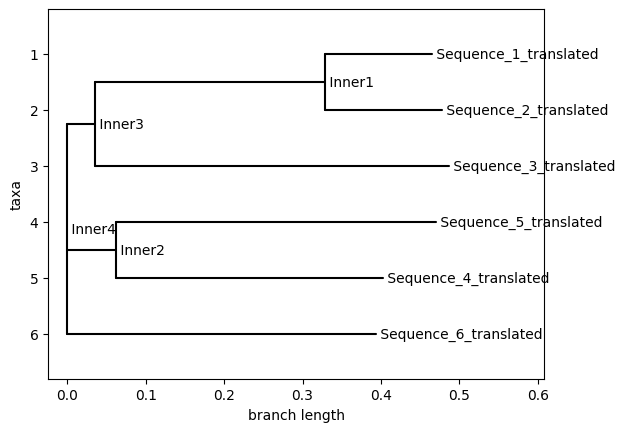

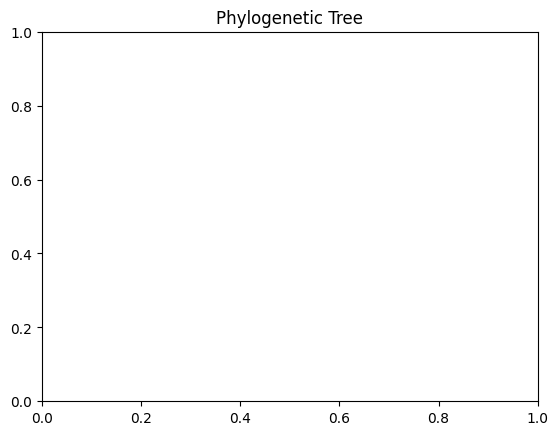

In [ ]:

# Generate phylogenetic trees for the aligned sequences and aligned protein sequences

from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

# Calculate the distance matrix (you already have this from the previous code)
# ... (your existing distance matrix calculation code) ...

# Create a DistanceCalculator object (for protein sequences)
calculator = DistanceCalculator("blosum62") # Use the BLOSUM62 matrix

# Calculate the distance matrix using the protein alignment
dm = calculator.get_distance(prot_alignment)

# Create a DistanceTreeConstructor object
constructor = DistanceTreeConstructor(calculator, 'nj') # Use the neighbor-joining method

# Construct the phylogenetic tree
tree = constructor.build_tree(prot_alignment)
#Or use the distance matrix directly
#tree = constructor.upgma(dm)

# Draw and title the tree
plt.figure(1)  # Create a figure for the tree
Phylo.draw(tree)
plt.title("Phylogenetic Tree")  # Add title
plt.show()

## Making predictions using BLAST Search and Hidden Markov Models

In [ ]:
# Convert the translated_sequences.fasta file into list format

translated_sequences = "/content/translated_sequences.fasta"

from Bio import SeqIO

def fasta_to_list(translated_sequences):
  """
  Converts a FASTA file into a list of sequences.

  Args:
    fasta_file: Path to the FASTA file.

  Returns:
    A list of sequences (strings) from the FASTA file.
  """
  sequences = []
  for record in SeqIO.parse(translated_sequences, "fasta"):
    sequences.append(str(record.seq))  # Convert Seq object to string
  return sequences

# Example usage:
fasta_file = "/content/translated_sequences.fasta"  # Replace with your file path
sequence_list = fasta_to_list(fasta_file)

# Print the list of sequences
print(sequence_list)

['MANTINLVTKFAPYVDEQFTSESKLSLLTNHDFDWTGAHTVKVYKIGTSAMNDYDRSGANVETNWSRFGPVAGLDAITEEMTLKKDRSFTFAIDKLDTDETAQQLAGATALARQNREVVIPEVDSYPYGIMATKAGTKPTAVTLTADNIYTEILKASETLDDAEVPETERVLVVSPSVYALMKKSADITLDSDVGQEQRMKGVIAMMDGAQVVKVPAVRLPENFGFMLAHPSATVAPVKLEDYRVHQDPPGLSGALVEGRICYDAFVLDNKVKAIYYMAQPSKA', 'MAIDLVAKFLPYVDEMFTTESKKSVLTNNDFQWTGAHTVKVYKINTAPMTDYDREGTGTGANGSRYGAVASLDATTEEFTLKKDRSFTFAIDKLDNDETVQQLGGATALARQQREIIIPEVDGYVYGVMCQNAGNKPAAITLTAENICDEIFKANTALDNAEVPETNRILVVTPDTYLLMKQSGDIFLNTDIAEDMRLKGIIAQFDGAKVIKVPSNRLPDDFGFMLVHPSATVAPTKLEDYKIHQDPPGISGDLVEGRICYDAFVLDNKKKAIYYQAVEGA', 'MTVKAMALNTNQLFAYLNRGDIAEFKFSPLFTTLFFPNVATFSTQNIMLDTLDIEEVTMSAFCSPMVGSQVQRDKGYETSTIKPGYMKPKHEIDPTKTIMRMAGEDPAQLNDPTYRRMRLITGNMRRQINAIKARVEWLAVNAVTTGKNIIEGEGIERYEIDWKIPEKNIIEQADGKKWSEQDKETHYPIYDIELYADQAGCPANVMIMGAEVWRTLRSFKKFRELYDLSRGSESAAELACKNLGEVVSFKGYLGDLALIVYSGKYTDSDGTEKYFLEPDLLVLGNTNNKGLVAYGAIMDQEAVRTGATQNMFYPKNWIEDGDPAIEYVQTHSAPQPVPADIRKFVTVKIA', 'MSKIAVIYARYSSDKQTEDSIEAQVRACREYAAAHGLSVVDVYTDEAISGKGSKTANRRQYQRLLRDCGK

In [ ]:
import os
import re
import requests
from io import StringIO

import pandas as pd
from Bio import SeqIO, Phylo
from Bio.Blast import NCBIWWW, NCBIXML
from lxml import etree

# Use the interactively provided FASTA file.
INPUT_FASTA = sequences_path
OUTPUT_DIR = "/content"

def blast_query(seq_record, program="blastx", db="nr", hitlist_size=5, out_dir=OUTPUT_DIR):
    """
    Executes a BLAST search on a sequence record and extracts function and organism predictions.

    Parameters:
        seq_record: A Bio.SeqRecord object.
        program (str): BLAST program (default "blastx").
        db (str): BLAST database (default "nr").
        hitlist_size (int): Number of hits to consider.
        out_dir (str): Directory to save BLAST results.

    Returns:
        tuple: (Function prediction string, organism prediction string)
    """
    sid = seq_record.id
    print(f"Starting BLAST for {sid}...")
    try:
        result_xml = NCBIWWW.qblast(program, db, seq_record.seq, hitlist_size=hitlist_size).read()
    except Exception as ex:
        print(f"BLAST error for {sid}: {ex}")
        result_xml = ""
    blast_file = os.path.join(out_dir, f"{sid}_blast.xml")
    with open(blast_file, "w") as fh:
        fh.write(result_xml)
    print(f"BLAST results for {sid} saved at {blast_file}.")

    func_hits, org_hits = [], []
    try:
        with open(blast_file) as fh:
            blast_rec = NCBIXML.read(fh)
            if blast_rec.alignments:
                for alignment in blast_rec.alignments[:hitlist_size]:
                    func_hits.append(alignment.hit_def)
                    m = re.search(r'\[(.*?)\]', alignment.hit_def)
                    org_hits.append(m.group(1) if m else "Unknown")
            else:
                print(f"No BLAST hits found for {sid}.")
    except Exception as ex:
        print(f"Error parsing BLAST output for {sid}: {ex}")

    return ("; ".join(func_hits) if func_hits else "No hit",
            "; ".join(org_hits) if org_hits else "Unknown")

def hmmer_query(protein_seq, sid, hmmdb="pfam", out_dir=OUTPUT_DIR):
    """
    Submits a protein sequence to the online HMMER service and retrieves the XML result.

    Parameters:
        protein_seq: Protein sequence (Bio.Seq object).
        sid (str): Sequence identifier.
        hmmdb (str): HMMER database (default "pfam").
        out_dir (str): Directory to save HMMER results.

    Returns:
        str: Raw XML result from HMMER.
    """
    url = "https://www.ebi.ac.uk/Tools/hmmer/search/hmmscan"
    payload = {"hmmdb": hmmdb, "seq": str(protein_seq), "domE": "1e-5"}
    headers = {"Expect": "", "Accept": "text/xml"}
    print(f"Submitting HMMER query for {sid}...")
    response = requests.post(url, data=payload, headers=headers)
    if response.status_code != 200:
        raise Exception(f"HMMER error for {sid}: {response.status_code}")
    xml_result = response.text
    hmmer_file = os.path.join(out_dir, f"{sid}_hmmer.xml")
    with open(hmmer_file, "w") as fh:
        fh.write(xml_result)
    print(f"HMMER results for {sid} stored at {hmmer_file}.")
    return xml_result

def extract_domains(xml_data):
    """
    Parses HMMER XML output and extracts domain predictions.

    Parameters:
        xml_data (str): Raw XML from HMMER.

    Returns:
        str: Semicolon-separated string of domain predictions.
    """
    domains = []
    try:
        parser = etree.XMLParser(recover=True)
        root = etree.fromstring(xml_data.encode("utf-8"), parser=parser)
        results = root.find(".//data[@name='results']")
        if results is not None:
            for hit in results.findall("hits"):
                hit_name = hit.get("name") or "UnknownHit"
                for dom in hit.findall("domains"):
                    dom_name = dom.get("alihmmname") or hit_name
                    e_val = dom.get("ievalue") or dom.get("evalue") or "N/A"
                    domains.append(f"{dom_name} (E={e_val})")
    except Exception as ex:
        print(f"Error parsing HMMER XML: {ex}")
    return "; ".join(domains) if domains else "No domains detected"

def run_prediction_pipeline(fasta_file=INPUT_FASTA, out_dir=OUTPUT_DIR):
    """
    Main pipeline that performs BLAST and online HMMER queries on each sequence,
    and saves domain, organism, and function predictions to CSV files.
    """
    records = list(SeqIO.parse(fasta_file, "fasta"))
    domain_results, org_func_results, overall_org = [], [], []

    for rec in records:
        sid = rec.id
        print(f"\nProcessing sequence {sid}...")
        func_pred, org_pred = blast_query(rec)
        org_func_results.append({
            "Sequence_ID": sid,
            "Predicted_Organism": org_pred,
            "Function_Prediction": func_pred
        })

        protein = rec.seq.translate(to_stop=True)
        try:
            hmmer_xml = hmmer_query(protein, sid)
        except Exception as ex:
            print(f"HMMER query failed for {sid}: {ex}")
            hmmer_xml = ""
        domain_results.append({
            "Sequence_ID": sid,
            "Domain_Predictions": extract_domains(hmmer_xml) if hmmer_xml else "No domains detected"
        })
        overall_org.append({
            "Sequence_ID": sid,
            "Predicted_Organism": org_pred
        })

    pd.DataFrame(domain_results).to_csv(os.path.join(out_dir, "domain_predictions.csv"), index=False)
    print(f"Domain predictions saved to {os.path.join(out_dir, 'domain_predictions.csv')}")

    pd.DataFrame(org_func_results).to_csv(os.path.join(out_dir, "organism_predictions.csv"), index=False)
    print(f"Organism & function predictions saved to {os.path.join(out_dir, 'organism_predictions.csv')}")

    pd.DataFrame(overall_org).to_csv(os.path.join(out_dir, "organism_overall.csv"), index=False)
    print(f"Overall organism predictions saved to {os.path.join(out_dir, 'organism_overall.csv')}")

# Execute the prediction pipeline.
run_prediction_pipeline()



Processing sequence Sequence_1...
Starting BLAST for Sequence_1...
BLAST results for Sequence_1 saved at /content/Sequence_1_blast.xml.
Submitting HMMER query for Sequence_1...
HMMER results for Sequence_1 stored at /content/Sequence_1_hmmer.xml.

Processing sequence Sequence_2...
Starting BLAST for Sequence_2...
BLAST results for Sequence_2 saved at /content/Sequence_2_blast.xml.
Submitting HMMER query for Sequence_2...
HMMER results for Sequence_2 stored at /content/Sequence_2_hmmer.xml.

Processing sequence Sequence_3...
Starting BLAST for Sequence_3...
BLAST results for Sequence_3 saved at /content/Sequence_3_blast.xml.
Submitting HMMER query for Sequence_3...
HMMER results for Sequence_3 stored at /content/Sequence_3_hmmer.xml.

Processing sequence Sequence_4...
Starting BLAST for Sequence_4...
BLAST results for Sequence_4 saved at /content/Sequence_4_blast.xml.
Submitting HMMER query for Sequence_4...
HMMER results for Sequence_4 stored at /content/Sequence_4_hmmer.xml.

Process